In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ATM_Forecating_system/district_month_MODEL_READY_LAGS.csv")

TARGET = "district_atm_withdrawal_volume_mn"

FEATURES = [c for c in df.columns if c != TARGET]

# Time-based split
train = df[df["year"] <= 2021]
val   = df[(df["year"] >= 2022) & (df["year"] <= 2023)]
test  = df[df["year"] >= 2024]

X_train, y_train = train[FEATURES], train[TARGET]
X_val, y_val     = val[FEATURES], val[TARGET]
X_test, y_test   = test[FEATURES], test[TARGET]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred_val = X_val["lag_1"]
y_pred_test = X_test["lag_1"]

print("Baseline MAE (val):", mean_absolute_error(y_val, y_pred_val))
print("Baseline RMSE (val):", np.sqrt(mean_squared_error(y_val, y_pred_val)))

Baseline MAE (val): 0.010981344949508488
Baseline RMSE (val): 0.016347579197896075


In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def evaluate(model, X_tr, y_tr, X_val, y_val, name="Model"):
    model.fit(X_tr, y_tr)

    val_preds = model.predict(X_val)

    mae = mean_absolute_error(y_val, val_preds)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))

    print(f"{name} → MAE (val): {mae:.6f}, RMSE (val): {rmse:.6f}")
    return mae, rmse

In [ ]:
lin_reg=Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
evaluate(lin_reg,X_train,y_train,X_val,y_val,"Linear Regression")

Linear Regression → MAE (val): 0.007850, RMSE (val): 0.011538


(0.007849692184419624, np.float64(0.011538160800481338))

In [ ]:
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

evaluate(ridge, X_train, y_train, X_val, y_val, "Ridge Regression")


Ridge Regression → MAE (val): 0.007857, RMSE (val): 0.011438


(0.00785728724840821, np.float64(0.011437966676814605))

In [ ]:
lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=0.001, max_iter=5000))
])

evaluate(lasso, X_train, y_train, X_val, y_val, "Lasso Regression")


Lasso Regression → MAE (val): 0.010382, RMSE (val): 0.013407


(0.010381844279625444, np.float64(0.013407125640299307))

In [ ]:
elastic = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=5000))
])

evaluate(elastic, X_train, y_train, X_val, y_val, "ElasticNet")


ElasticNet → MAE (val): 0.009247, RMSE (val): 0.012401


(0.009246880076094323, np.float64(0.012400740036739322))

In [ ]:
ridge.fit(X_train, y_train)

coefs = pd.Series(
    ridge.named_steps["model"].coef_,
    index=X_train.columns
).sort_values(key=abs, ascending=False)

coefs.head(10)


,0
upi_txn_volume_mn,0.030829
business_activity_index,0.026756
digital_share_txn,-0.012958
atm_share_txn,0.012958
roll_mean_6,0.011997
literacy_rate,-0.011921
working_age_pct,-0.011921
median_income_k,-0.008810
lag_1,0.007755
year,-0.007643


In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(
    max_depth=8,
    min_samples_leaf=200,
    random_state=42
)

evaluate(dt, X_train, y_train, X_val, y_val, "Decision Tree")

Decision Tree → MAE (val): 0.012066, RMSE (val): 0.017491


(0.01206643400653851, np.float64(0.017491082361253157))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=14,
    min_samples_leaf=100,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

evaluate(rf, X_train, y_train, X_val, y_val, "Random Forest")

Random Forest → MAE (val): 0.008771, RMSE (val): 0.013314


(0.008771308095521346, np.float64(0.013314140149119982))

In [ ]:
fi = pd.Series(
    rf.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

fi.head(10)

,0
lag_1,0.179632
roll_mean_3,0.173355
roll_mean_6,0.132839
lag_2,0.090945
lag_3,0.090463
num_atms,0.066945
population_total_k,0.059507
lag_6,0.043396
ntl_index_mean,0.039443
digital_share_txn,0.025114


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

evaluate(gbr, X_train, y_train, X_val, y_val, "Gradient Boosting")

Gradient Boosting → MAE (val): 0.008884, RMSE (val): 0.012856


(0.008883662070684988, np.float64(0.012856299276848665))

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

ridge = Ridge(alpha=1.0)
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

ridge.fit(X_train_full, y_train_full)
rf.fit(X_train_full, y_train_full)
gbr.fit(X_train_full, y_train_full)


GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          random_state=42)

In [ ]:
ridge_pred = ridge.predict(X_test)
rf_pred = rf.predict(X_test)
gbr_pred = gbr.predict(X_test)

ensemble_pred = (
    0.4 * ridge_pred +
    0.3 * rf_pred +
    0.3 * gbr_pred
)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, ensemble_pred)
rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))

print(f"ENSEMBLE → MAE (test): {mae:.6f}")
print(f"ENSEMBLE → RMSE (test): {rmse:.6f}")


ENSEMBLE → MAE (test): 0.006039
ENSEMBLE → RMSE (test): 0.009600


In [ ]:
fi=pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

fi.head(10)

,0
roll_mean_3,0.881221
lag_1,0.041694
atm_share_txn,0.016308
digital_share_txn,0.013903
lag_12,0.007196
roll_std_3,0.006131
month_num,0.005712
roll_std_6,0.005392
roll_mean_6,0.003299
lag_6,0.002999


In [ ]:
coef = pd.Series(ridge.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)
coef.head(10)


,0
roll_std_6,0.176335
lag_1,0.171560
digital_share_txn,-0.161150
atm_share_txn,0.161150
roll_mean_6,0.150804
roll_mean_3,0.093446
lag_3,0.076049
business_activity_index,0.065116
roll_std_3,0.052973
lag_12,0.052310


In [ ]:
import shap
import numpy as np


X_shap = X_test.sample(n=500, random_state=42)


In [ ]:
explainer = shap.TreeExplainer(
    rf,
    feature_perturbation="tree_path_dependent"
)

shap_values = explainer.shap_values(X_shap)


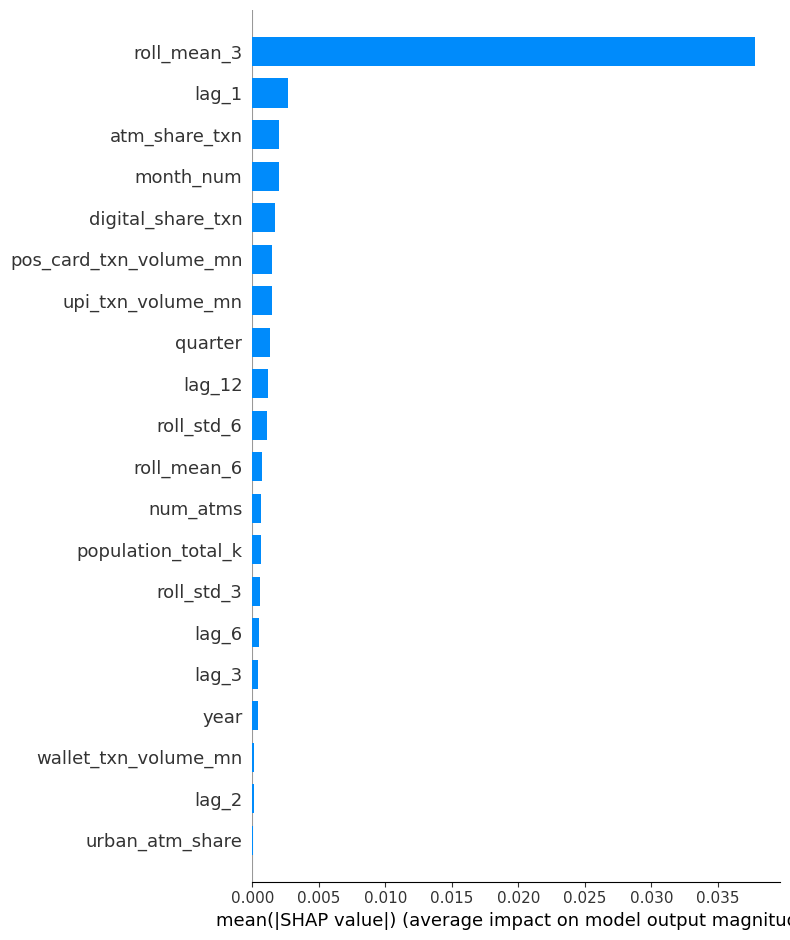

In [ ]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")


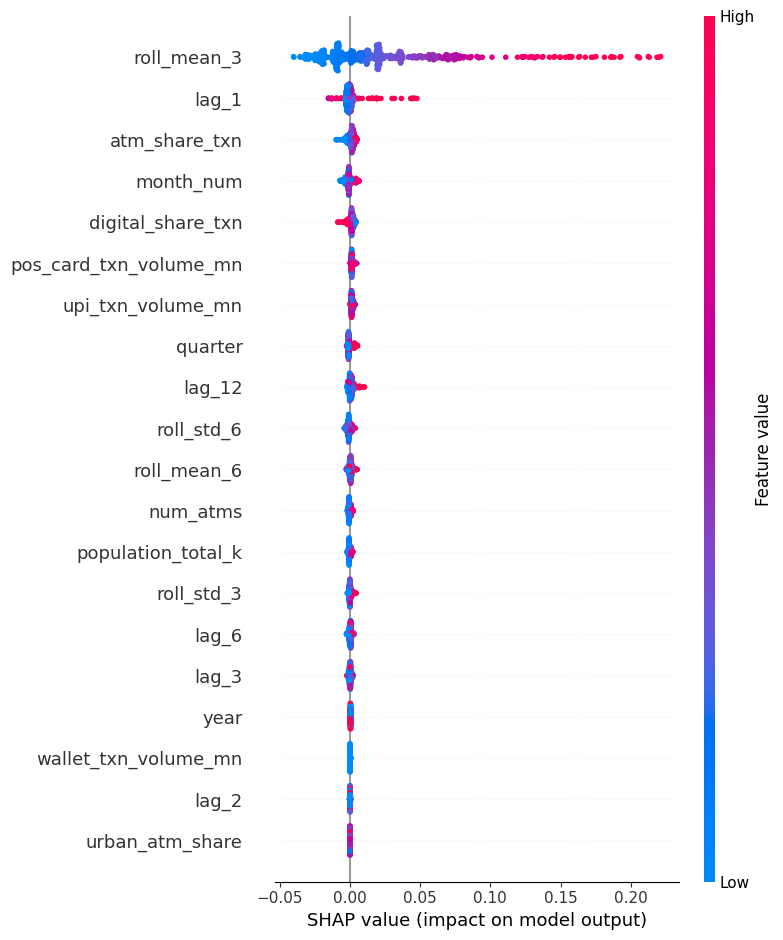

In [ ]:
shap.summary_plot(shap_values, X_shap)


In [ ]:
import joblib
import os

SAVE_DIR = "/content/drive/MyDrive/ATM_Forecating_system/models"
os.makedirs(SAVE_DIR, exist_ok=True)
joblib.dump(lin_reg,   f"{SAVE_DIR}/linear_regression.pkl")
joblib.dump(ridge,          f"{SAVE_DIR}/ridge.pkl")
joblib.dump(lasso,          f"{SAVE_DIR}/lasso.pkl")
joblib.dump(elastic,        f"{SAVE_DIR}/elasticnet.pkl")
joblib.dump(dt,             f"{SAVE_DIR}/decision_tree.pkl")
joblib.dump(rf,             f"{SAVE_DIR}/random_forest.pkl")
joblib.dump(gbr,             f"{SAVE_DIR}/gradient_boosting.pkl")
joblib.dump(ensemble_pred, f"{SAVE_DIR}/ensemble.pkl")

print("✅ All models saved successfully")


✅ All models saved successfully


In [ ]:
import pandas as pd

df_full = pd.read_csv(
    "/content/drive/MyDrive/ATM_Forecating_system/master_district_month_clean.csv"
)

df_full["date"] = pd.to_datetime(
    df_full["year"].astype(str) + "-" +
    df_full["month_num"].astype(str) + "-01"
)


In [ ]:
plot_df = test.copy()

plot_df["actual"] = y_test.values
plot_df["predicted"] = ensemble_pred


plot_df["district_name"] = df_full.loc[plot_df.index, "district_name"].values

plot_df["date"] = pd.to_datetime(
    plot_df["year"].astype(str) + "-" +
    plot_df["month_num"].astype(str) + "-01"
)


In [ ]:
pune_df = plot_df[plot_df["district_name"] == "pune"]


pune_sample = pune_df.sort_values("date").head(24)


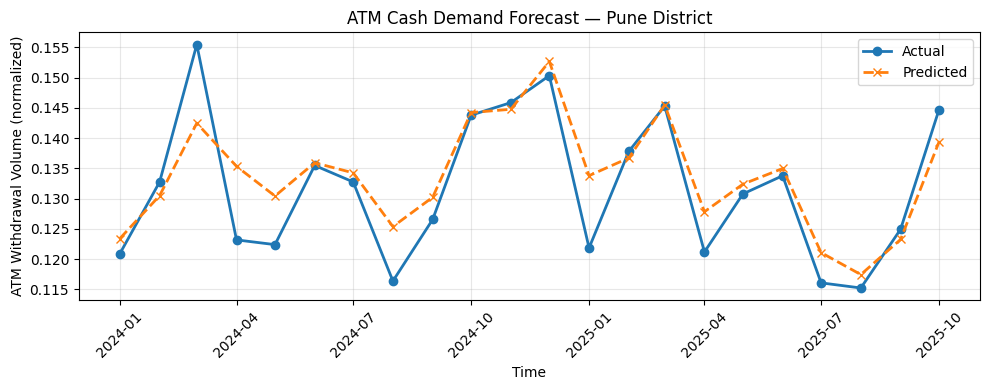

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.plot(
    pune_sample["date"],
    pune_sample["actual"],
    marker="o",
    linewidth=2,
    label="Actual"
)

plt.plot(
    pune_sample["date"],
    pune_sample["predicted"],
    marker="x",
    linestyle="--",
    linewidth=2,
    label="Predicted"
)

plt.title("ATM Cash Demand Forecast — Pune District")
plt.xlabel("Time")
plt.ylabel("ATM Withdrawal Volume (normalized)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    early_stopping_rounds=50   
)
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
val_pred = xgb.predict(X_val)

mae_val = mean_absolute_error(y_val, val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"XGBoost → MAE (val): {mae_val:.6f}")
print(f"XGBoost → RMSE (val): {rmse_val:.6f}")



XGBoost → MAE (val): 0.007990
XGBoost → RMSE (val): 0.010935


In [ ]:
test_pred = xgb.predict(X_test)

mae_test = mean_absolute_error(y_test, test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"XGBoost → MAE (test): {mae_test:.6f}")
print(f"XGBoost → RMSE (test): {rmse_test:.6f}")


XGBoost → MAE (test): 0.008717
XGBoost → RMSE (test): 0.012737


In [ ]:
joblib.dump(xgb, "/content/drive/MyDrive/ATM_Forecating_system/models/xgboost.pkl")
print("✅ XGBoost model saved successfully")


✅ XGBoost model saved successfully
